<a href="https://colab.research.google.com/github/kyoungyi/2023_Crops_Hydroclimatic_Hazards/blob/main/code/neuralGCM_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if necessary, install NeuralGCM and dependencies
! pip install -q -U neuralgcm dinosaur-dycore gcsfs

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
! cd /content/drive/MyDrive/Colab Notebooks/ATS

/bin/bash: line 1: cd: too many arguments


# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/google-research/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [4]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`



In [5]:
model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details.

Select out a few days of data:

In [6]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

demo_start_time = '2012-07-17'
demo_end_time = '2012-07-19'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM's native resolution:

In [7]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast

See {doc}`trained_models` for details.

In [8]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

In [9]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times[:3])



ValueError: Value of shape (3, 37, 256, 128) is not in shape_to_dims={(4,): ('time',), (4, 37, 256, 129): ('time', 'level', 'longitudinal_mode', 'total_wavenumber'), (4, 37, 256, 128): ('time', 'level', 'lon', 'lat'), (4, 256, 128): ('time', 'lon', 'lat'), (4, 256, 129): ('time', 'longitudinal_mode', 'total_wavenumber'), (4, 1, 256, 128): ('time', 'surface', 'lon', 'lat'), (4, 1, 256, 129): ('time', 'surface', 'longitudinal_mode', 'total_wavenumber'), (4, 1): ('time', 'surface')}

In [12]:
target_data_ds = model.data_to_xarray(target_trajectory, times=times[:3])

In [13]:
combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [14]:
combined_ds.head()

<xarray.Dataset> Size: 28kB
Dimensions:                              (model: 2, time: 4, level: 5,
                                          longitude: 5, latitude: 5)
Coordinates:
  * longitude                            (longitude) float64 40B 0.0 ... 5.625
  * latitude                             (latitude) float64 40B -88.93 ... -8...
  * level                                (level) int64 40B 1 2 3 5 7
  * time                                 (time) int64 32B 0 24 48 72
  * model                                (model) <U9 72B 'ERA5' 'NeuralGCM'
Data variables:
    specific_cloud_liquid_water_content  (model, time, level, longitude, latitude) float32 4kB ...
    geopotential                         (model, time, level, longitude, latitude) float32 4kB ...
    sim_time                             (model, time) float64 64B 1.544e+05 ...
    v_component_of_wind                  (model, time, level, longitude, latitude) float32 4kB ...
    specific_cloud_ice_water_content     (model, time, level, longitude, latitude) float32 4kB ...
    specific_humidity                    (model, time, level, longitude, latitude) float32 4kB ...
    temperature                          (model, time, level, longitude, latitude) float32 4kB ...
    u_component_of_wind                  (model, time, level, longitude, latitude) float32 4kB ...
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

In [18]:
combined_ds.to_zarr('drive/MyDrive/Colab Notebooks/ATS/neuralgcm_2012_output.zarr')

In [21]:
! rm -r neuralgcm_2012_output.zarr

In [27]:
combined_ds.sel(level=1000).sel(longitude=slice(60, 120), latitude=slice(25, 52))

<xarray.Dataset> Size: 184kB
Dimensions:                              (model: 2, time: 4, longitude: 43,
                                          latitude: 19)
Coordinates:
  * longitude                            (longitude) float64 344B 60.47 ... 1...
  * latitude                             (latitude) float64 152B 25.91 ... 51.13
    level                                int64 8B 1000
  * time                                 (time) int64 32B 0 24 48 72
  * model                                (model) <U9 72B 'ERA5' 'NeuralGCM'
Data variables:
    specific_cloud_liquid_water_content  (model, time, longitude, latitude) float32 26kB ...
    geopotential                         (model, time, longitude, latitude) float32 26kB ...
    sim_time                             (model, time) float64 64B 1.544e+05 ...
    v_component_of_wind                  (model, time, longitude, latitude) float32 26kB ...
    specific_cloud_ice_water_content     (model, time, longitude, latitude) float32 26kB ...
    specific_humidity                    (model, time, longitude, latitude) float32 26kB ...
    temperature                          (model, time, longitude, latitude) float32 26kB ...
    u_component_of_wind                  (model, time, longitude, latitude) float32 26kB ...
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

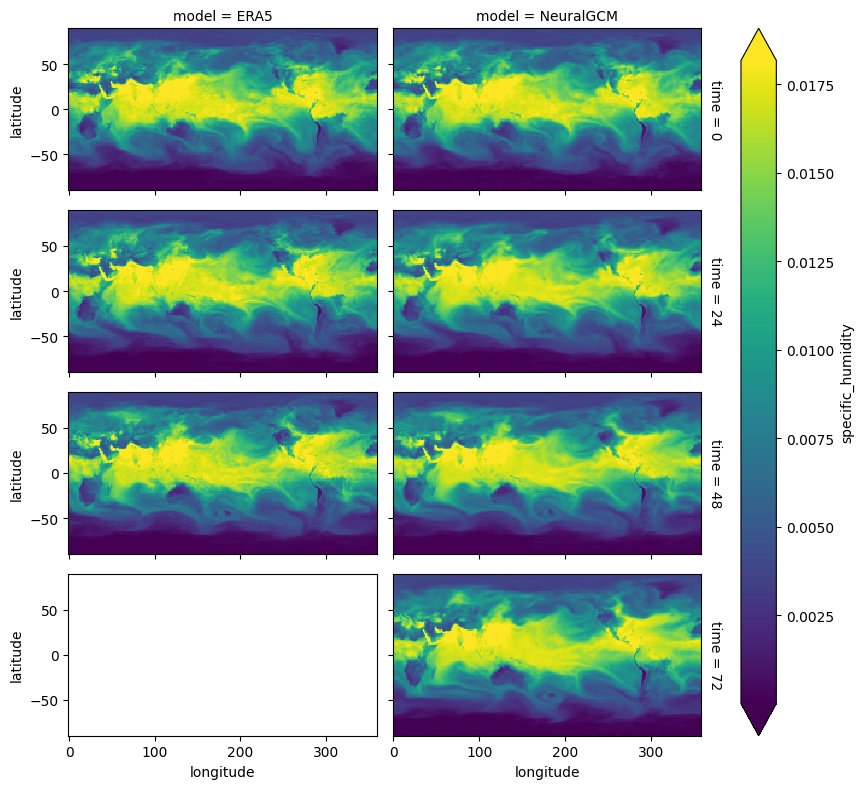

In [22]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=1000).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

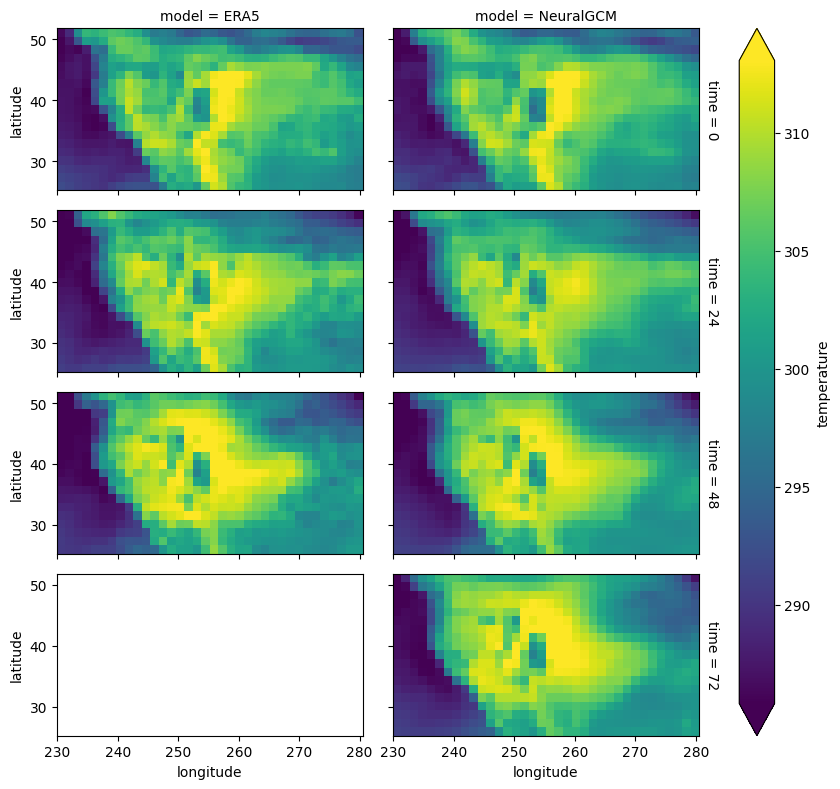

In [30]:
combined_ds.temperature.sel(level=1000).sel(longitude=slice(230, 280), latitude=slice(25, 52)).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

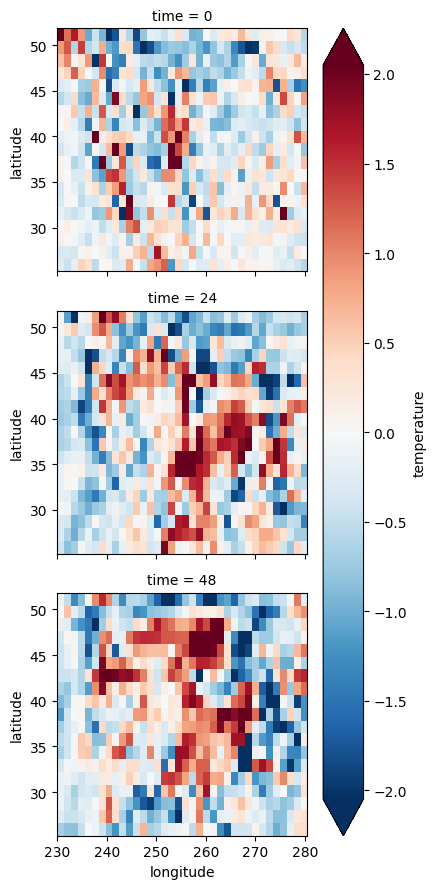

In [38]:
(combined_ds.temperature.isel(time=slice(0,3)).sel(level=1000).sel(longitude=slice(230, 280), latitude=slice(25, 52)).sel(model='ERA5') -
 combined_ds.temperature.isel(time=slice(0,3)).sel(level=1000).sel(longitude=slice(230, 280), latitude=slice(25, 52)).sel(model='NeuralGCM')).plot(
    x='longitude', y='latitude', row='time', robust=True, aspect=1)